In [68]:
import pandas as pd
import os 
import glob 
import math 
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib import patches as patches

In [69]:
# methods to plot objects in arenas

def plot_arena(ax):
    # arena: arena.world 
    ax.add_patch(patches.Rectangle((-5,-5), 1, 10, edgecolor='grey', facecolor='none'))
    ax.add_patch(patches.Rectangle((4,-5), 1, 10, edgecolor='grey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-5,-5), 10, 1, edgecolor='grey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-5,4), 10, 1, edgecolor='grey', facecolor='none'))

    
def plot_arena_large(ax):
    # arena: arena_large.world
    ax.add_patch(patches.Rectangle((-10,-10), 1, 20, edgecolor='grey', facecolor='none'))
    ax.add_patch(patches.Rectangle((9,-10), 1, 20, edgecolor='grey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-10,-10), 20, 1, edgecolor='grey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-10,9), 20, 1, edgecolor='grey', facecolor='none'))

    
def plot_two_rooms(ax): 
    # arena: two_rooms.world
    ax.add_patch(patches.Rectangle((-10,-8), 1, 16, edgecolor='grey', facecolor='none'))
    ax.add_patch(patches.Rectangle((9,-8), 1, 16, edgecolor='grey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-2,2), 1, 6, edgecolor='grey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-2,-8), 1, 6, edgecolor='grey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-10,7), 20, 1, edgecolor='grey', facecolor='none'))
    ax.add_patch(patches.Rectangle((-10,-8), 20, 1, edgecolor='grey', facecolor='none'))

In [119]:
# method to create visualization 

def create_plot(objects_x, objects_y, robots, lidar, arena, r, robot):
    # create plot with robots, obstacles and lidar data 
    
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.title(str(robot))
        
    if arena == 'arena':
        plot_arena(ax)
    elif arena == 'arena-large':
        plot_arena_large(ax)
    elif arena == "two-rooms":
        plot_two_rooms(ax) 


    plt.scatter(x=objects_x, y=objects_y, facecolors='none', edgecolors='blue') # objects except ground plane 
    plt.scatter(*robots.T, facecolors='none', edgecolors='orange') # robots 
    plt.scatter(*r.T, facecolors='none', edgecolors='green') # robots 
    plt.scatter(*lidar.T, s=0.4, color='red') # lidar 

In [125]:
# data frame processing 

def get_positions(df, idx):        
    # get object and robot positions from data frame 
    
    objects = [] 
    robots = [] 
    r = []
    angle = 0 
    
    # get object names  
    names = [el[1:-1] for el in df['poses'][idx].split('[')[1].split(']')[0].split(', ')] 

    string = df['poses'][idx]

    for i in range(0, len(names)):
        # get position 
        start = string.find('Point')
        stop = string[start:].find(')')
        pose = string[start+6:start+stop].split(', ')
        
        # get yaw angle (rotation around x-axis )
        string = string[start+6:]
        start = string.find('Quaternion')
        stop = string[start:].find(')')
        orientation = string[start+11:start+stop].split(', ')
        
        if names[i][:5] == "robot":
            robots.append([float(pose[0][2:]), float(pose[1][2:])])
            print(robots)
            if names[i] == df['robot'][idx]:
                r = [robots[-1][0], robots[-1][1]]
                angle = calculate_yaw(orientation)
                
        elif names[i] != "ground_plane": 
            objects.append([float(pose[0][2:]), float(pose[1][2:])])
    
    return np.array(objects), np.array(robots), np.array(r), angle 


def calculate_yaw(orientation):
    # calculate yaw angle (around x-axis)
    
    q_x = float(orientation[0][2:])
    q_y = float(orientation[1][2:])
    q_z = float(orientation[2][2:])
    q_w = float(orientation[3][2:])

    siny_cosp = 2 * (q_w * q_z + q_x * q_y)
    cosy_cosp = 1 - 2 * (q_y * q_y + q_z * q_z)

    return np.arctan2(siny_cosp, cosy_cosp)

    
def transform_lidar(df, r, angle, idx):  
    # transform lidar data from angle - distance to point 
    
    # get lidar data 
    ld = [float(el) for el in df['scan'][idx].split('ranges=[')[1].split('],')[0].split(',')]
        
    # transform lidar data to x, y positions 
        
    lidar = np.empty(shape=(360,2))

    for i in range(0, 360): 
        if not math.isinf(ld[i]):
            lidar[i][0] = ld[i] * math.cos(angle + np.deg2rad(i)) + r[0]
            lidar[i][1] = ld[i] * math.sin(angle + np.deg2rad(i)) + r[1]
        else: 
            lidar[i][0] = float('inf')
            lidar[i][1] = float('inf')
    
    return lidar

[[7.267982779541445e-05, -1.0000005184362066]]
[[7.267982779541445e-05, -1.0000005184362066], [8.470194721440605e-05, -3.059184017046828e-07]]
[[7.267982779541445e-05, -1.0000005184362066], [8.470194721440605e-05, -3.059184017046828e-07], [5.578251997500731e-05, 0.9999998302401104]]
[[7.267982779541445e-05, -1.0000005184362066]]
[[7.267982779541445e-05, -1.0000005184362066], [8.470194721440605e-05, -3.059184017046828e-07]]
[[7.267982779541445e-05, -1.0000005184362066], [8.470194721440605e-05, -3.059184017046828e-07], [5.578251997500731e-05, 0.9999998302401104]]
[[7.267982779541445e-05, -1.0000005184362066]]
[[7.267982779541445e-05, -1.0000005184362066], [8.470194721440605e-05, -3.059184017046828e-07]]
[[7.267982779541445e-05, -1.0000005184362066], [8.470194721440605e-05, -3.059184017046828e-07], [5.578251997500731e-05, 0.9999998302401104]]
[[4.382049287969206e-05, 0.9999976532403146]]
[[4.382049287969206e-05, 0.9999976532403146], [8.380684021379671e-05, -2.9110307371588174e-07]]
[[4.38

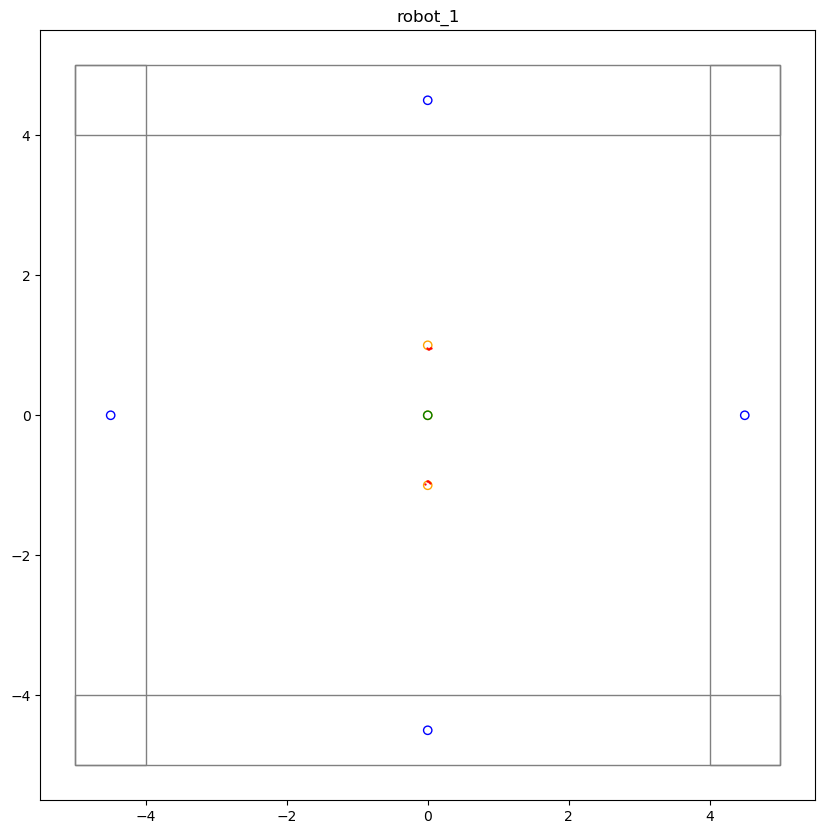

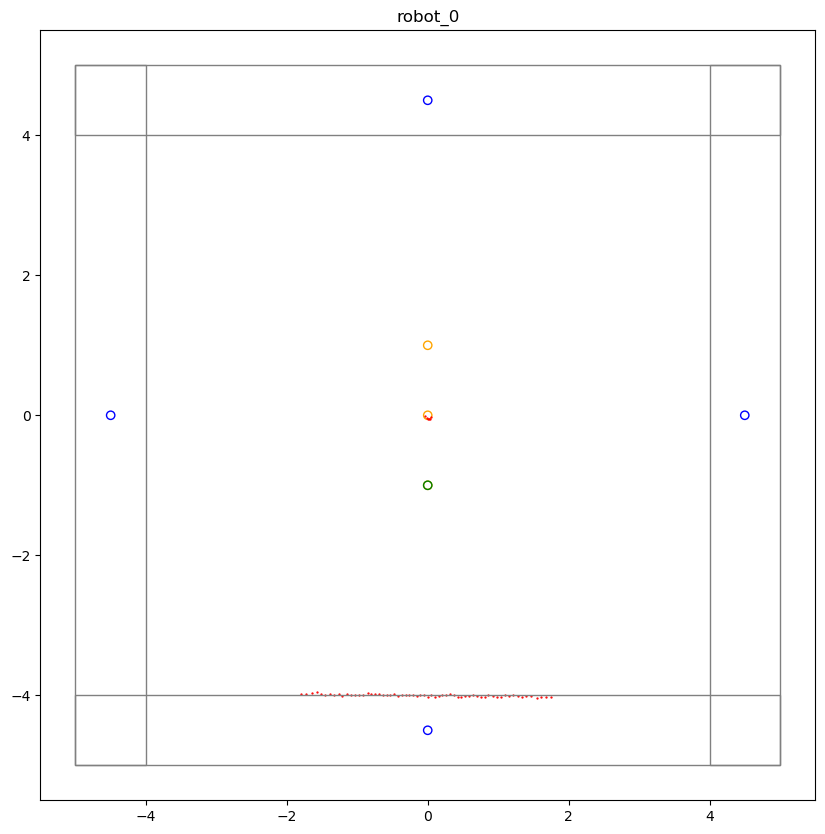

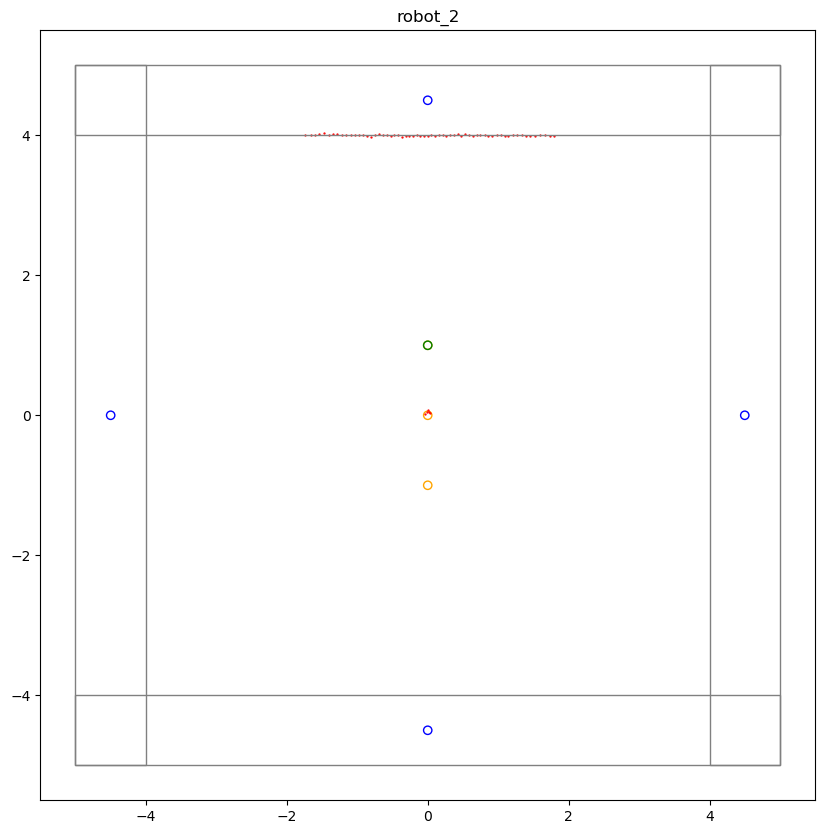

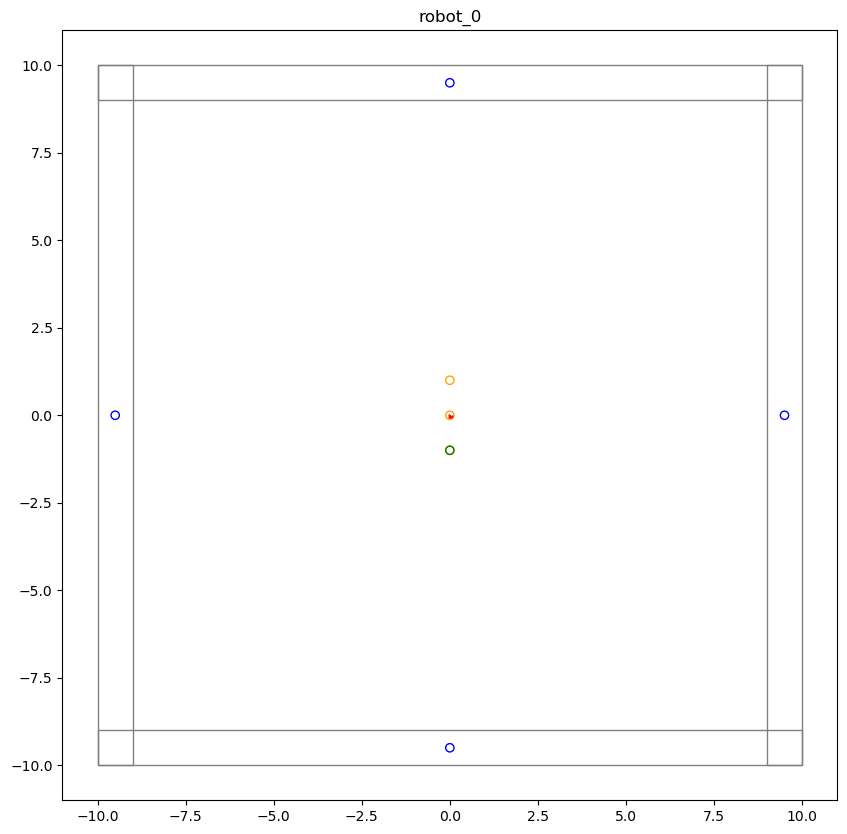

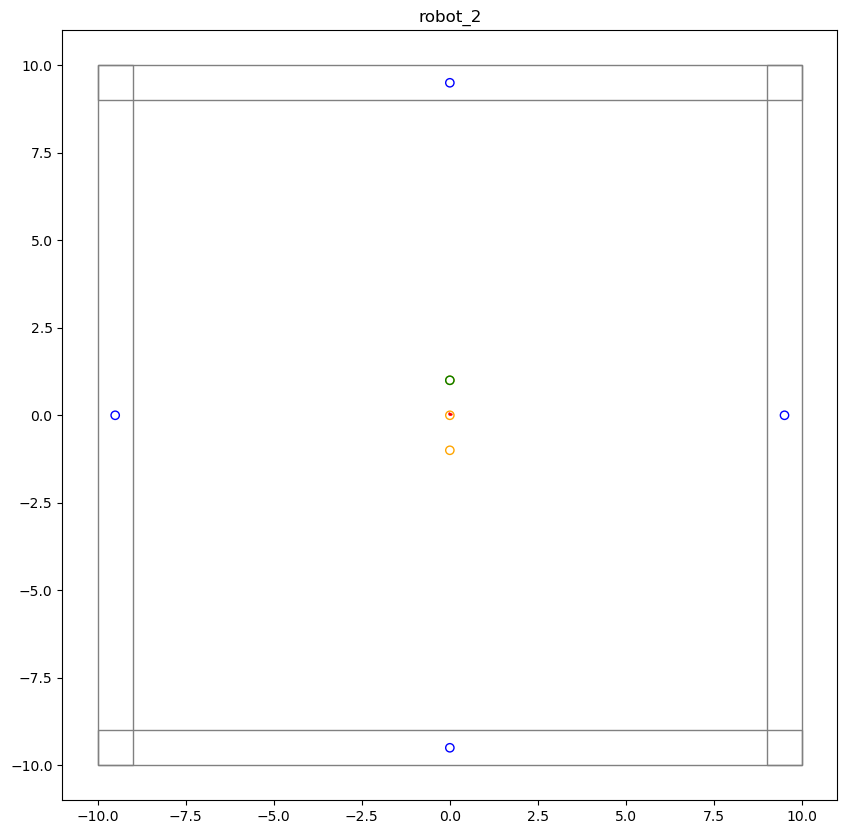

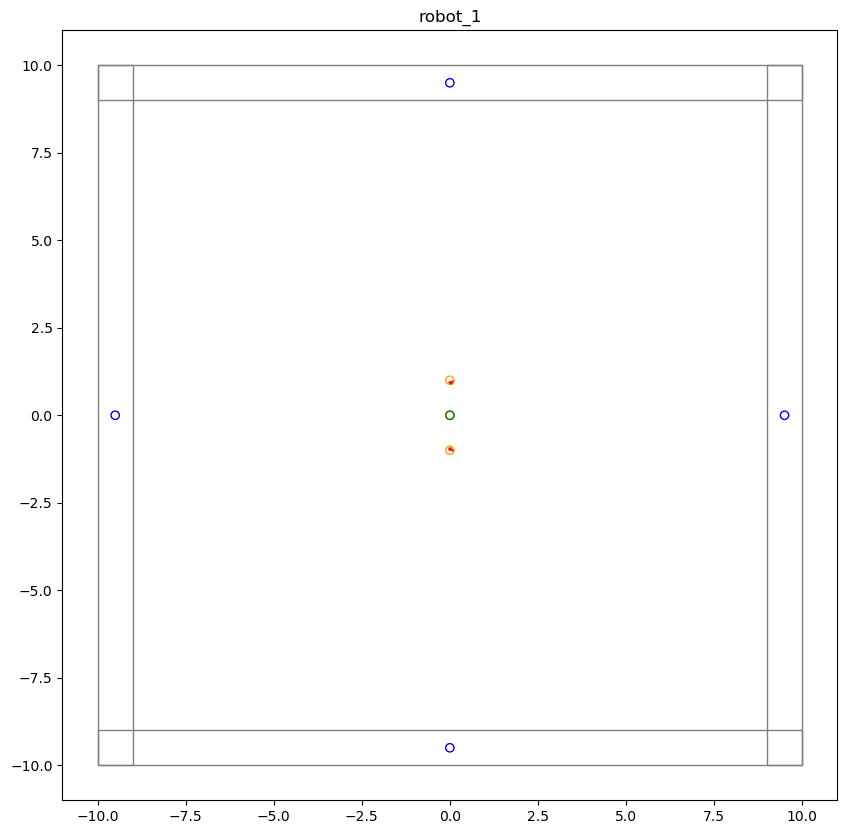

In [126]:
# main function 

def main(idx=0): 
    # get folders with rosbags / lidar data  
    subfolders = [f.name for f in os.scandir('./') if f.is_dir() and f.name[:1] != '.']

    for subfolder in subfolders: 
        files = glob.glob(subfolder+'/*.csv')
        arena = subfolder.split('_')[0]

        for f in files:  

            df = pd.read_csv(f)

            # get robot and object positions 
            objects_x, objects_y, robots, r, angle = get_positions(df, idx) 
            
            # transform lidar scans to points 
            lidar = transform_lidar(df, r, angle, idx)
            
            # create plot 
            create_plot(objects_x, objects_y, robots, lidar, arena, r, df['robot'][idx])
        
        
if __name__ == "__main__":

    main()